# Localized Entropy Cost Function

- Inputs: numeric features + condition embedding (synthetic: Age, log10(NetWorth); CTR: numeric columns + device_type).
- Data source: real click-through-rate dataset by default (files in `data/train.csv` and `data/test.csv`), with a synthetic generator option.
- Labels are observed clicks (train) and used directly (true probabilities are only for synthetic data).
- Split 90/10 into train/eval (CTR uses a random split from the train file).
- Loss supports localized entropy or BCE; eval can compare both.
- Experiment config system: `BASE_EXPERIMENT` + named presets in `EXPERIMENTS`, selected by `ACTIVE_EXPERIMENT` with optional `EXPERIMENT_OVERRIDES`.
- After training: plot loss curves, summarize predictions, and optionally plot condition/localized-entropy stats.


In [1]:

%matplotlib inline
from typing import Tuple, List, Optional
import os
os.environ["LOCALIZED_ENTROPY_NUM_WORKERS"] = "1"
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn-v0_8')
np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
NON_BLOCKING = USE_CUDA

if USE_CUDA:
    gpu_name = torch.cuda.get_device_name(device)
    print(f'Using CUDA device: {gpu_name}')
    torch.backends.cudnn.benchmark = True
else:
    print('CUDA not available, defaulting to CPU.')

device

CUDA not available, defaulting to CPU.


device(type='cpu')

In [2]:
# Probability generation
def _sigmoid(x: np.ndarray,
             mu: float,
             s: float) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-(x - mu) / s))

def generate_probs(
    num_samples: int,
    mu_ln: float,
    sigma_ln: float,
    sig_mu: float,
    sig_s: float,
    mu_age: float,
    sigma_age: float,
    interestScale: float,
    min_age: int = 10,
    max_age: int = 100,
    rng: Optional[np.random.Generator] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Implements generation logic and returns
    (net_worth, ages, probabilities).
    """
    if rng is None:
        rng = np.random.default_rng()

    net_worth = rng.lognormal(mean=mu_ln, sigma=sigma_ln, size=num_samples)
    probs = _sigmoid(np.log10(net_worth + 1.0), mu=sig_mu, s=sig_s)

    ages = rng.integers(min_age, max_age, size=num_samples)
    denom = norm.pdf(50, loc=mu_age, scale=sigma_age)
    denom = denom if denom > 0 else 1.0
    interest_prob = norm.pdf(ages, loc=mu_age, scale=sigma_age) / denom
    interest_prob = interest_prob / interestScale

    probs = probs * interest_prob
    probs = np.clip(probs, 0.0, 1.0)
    return net_worth.astype(np.float32), ages.astype(np.float32), probs.astype(np.float32)

def sample_condition_params(rng: np.random.Generator) -> Tuple[float, float, float, float, float, float, float]:
    # Parameter ranges
    mu_ln = 10.0
    sigma_ln = 1.5
    sig_mu = rng.choice(np.linspace(5, 7, 50))
    sig_s = rng.choice(np.linspace(0.2, 0.3, 50))
    mu_age = rng.choice(np.linspace(30, 70, 50))
    sigma_age = rng.choice(np.linspace(10, 30, 50))
    interestScale = 10.0 ** (rng.choice(np.linspace(0, 0.001, 50)))
    return mu_ln, sigma_ln, sig_mu, sig_s, mu_age, sigma_age, interestScale

def make_dataset(
    num_conditions: int,
    min_samples_per_condition: int = 90_000,
    max_samples_per_condition: int = 100_000,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns: ages, net_worth, condition_ids, labels, probs
    Labels are sampled via Binomial(1, p)
    """
    rng = np.random.default_rng(seed)
    ages_all, nw_all, conds_all, labels_all, probs_all = [], [], [], [], []
    for cond in range(num_conditions):
        n = int(rng.integers(min_samples_per_condition, max_samples_per_condition + 1))
        params = sample_condition_params(rng)
        net_worth, ages, probs = generate_probs(n, *params, rng=rng)
        labels = rng.binomial(n=1, p=probs).astype(np.float32)
        ages_all.append(ages)
        nw_all.append(net_worth)
        conds_all.append(np.full_like(ages, fill_value=cond, dtype=np.float32))
        labels_all.append(labels)
        probs_all.append(probs)
    ages = np.concatenate(ages_all, axis=0)
    net_worth = np.concatenate(nw_all, axis=0)
    conds = np.concatenate(conds_all, axis=0)
    labels = np.concatenate(labels_all, axis=0)
    probs = np.concatenate(probs_all, axis=0)
    return ages, net_worth, conds.astype(np.int64), labels, probs

In [3]:
# Plotting helpers
def _density_lines(
    values: np.ndarray,
    groups: np.ndarray,
    num_conditions: int,
    *,
    bins: int = 100,
    transform: Optional[str] = None,  # None or 'log10'
    value_range: Optional[Tuple[float, float]] = None,
    title: str = '',
    x_label: str = ''
) -> None:
    vals = values.astype(np.float64).copy()
    if transform == 'log10':
        eps = 1e-12
        vals = np.log10(np.clip(vals, eps, None))
    if value_range is None:
        vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))
    else:
        vmin, vmax = value_range
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0
    edges = np.linspace(vmin, vmax, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    plt.figure(figsize=(10, 6))
    for cond in range(int(num_conditions)):
        m = groups == cond
        if not np.any(m):
            continue
        vv = vals[m]
        hist, _ = np.histogram(vv, bins=edges, density=True)
        plt.plot(centers, hist, label=f'Condition {cond}')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_training_distributions(net_worth: np.ndarray,
                                ages: np.ndarray,
                                probs: np.ndarray,
                                conds: np.ndarray,
                                num_conditions: int) -> None:
    _density_lines(
        values=net_worth,
        groups=conds,
        num_conditions=num_conditions,
        bins=120,
        transform='log10',
        title='Training Data: Distribution by Condition (log10(NetWorth))',
        x_label='log10(NetWorth)'
    )
    _density_lines(
        values=ages,
        groups=conds,
        num_conditions=num_conditions,
        bins=120,
        transform=None,
        title='Training Data: Distribution by Condition (Age)',
        x_label='Age'
    )
    _density_lines(
        values=probs,
        groups=conds,
        num_conditions=num_conditions,
        bins=120,
        transform='log10',
        value_range=(-12, 0),
        title='Training Data: Distribution by Condition (log10(true probability))',
        x_label='log10(true p)'
    )

def plot_eval_log10p_hist(preds: np.ndarray, epoch: int, bins: int = 100) -> None:
    eps = 1e-12
    log10p = np.log10(np.clip(preds, eps, 1.0))
    plt.figure(figsize=(8, 5))
    plt.hist(log10p, bins=bins, range=(-12, 0), density=True, color='#4477aa', alpha=0.85)
    plt.title(f'Eval Predicted Probability: log10(p) (Epoch {epoch})')
    plt.xlabel('log10(pred p)')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
# Dataset (numeric features + categorical condition)
class MedCondDataset(Dataset):
    def __init__(
        self,
        x_num: np.ndarray,
        conds: np.ndarray,
        labels: np.ndarray,
        net_worth: Optional[np.ndarray] = None,
        share_memory: bool = False,
    ):
        assert x_num.ndim == 2 and x_num.shape[1] >= 1
        assert len(x_num) == len(conds) == len(labels)
        self.x = torch.as_tensor(x_num, dtype=torch.float32).contiguous()
        self.c = torch.as_tensor(conds, dtype=torch.long).contiguous()
        self.y = torch.as_tensor(labels, dtype=torch.float32).contiguous()
        if net_worth is None:
            self.nw = torch.zeros(len(labels), dtype=torch.float32)
        else:
            assert len(net_worth) == len(labels)
            self.nw = torch.as_tensor(net_worth, dtype=torch.float32).contiguous()
        if share_memory:
            for tensor in (self.x, self.c, self.y, self.nw):
                if tensor.device.type == 'cpu':
                    tensor.share_memory_()
    def __len__(self) -> int:
        return self.y.numel()
    def __getitem__(self, idx: int):
        return (
            self.x[idx],
            self.c[idx],
            self.y[idx],
            self.nw[idx],
        )

class TensorBatchLoader:
    def __init__(self,
                 tensors: Tuple[torch.Tensor, ...],
                 batch_size: int,
                 shuffle: bool):
        assert len(tensors) > 0
        n = tensors[0].shape[0]
        for t in tensors[1:]:
            assert t.shape[0] == n, 'All tensors must share the first dimension.'
        self.tensors = tensors
        self.batch_size = int(max(1, batch_size))
        self.shuffle = shuffle
        self.length = n
        self.device = tensors[0].device
    def __len__(self) -> int:
        return (self.length + self.batch_size - 1) // self.batch_size
    @property
    def num_workers(self) -> int:
        return 0
    def __iter__(self):
        indices = torch.arange(self.length, device=self.device, dtype=torch.long)
        if self.shuffle:
            indices = indices[torch.randperm(self.length, device=self.device)]
        for start in range(0, self.length, self.batch_size):
            batch_idx = indices[start:start + self.batch_size]
            yield tuple(t.index_select(0, batch_idx) for t in self.tensors)

class ConditionProbNet(nn.Module):
    def __init__(
        self,
        num_conditions: int,
        num_numeric: int = 2,
        embed_dim: int = 16,
        hidden_sizes: Optional[Tuple[int, ...]] = None,
        p_drop: float = 0.3,
    ):
        super().__init__()
        if hidden_sizes is None:
            hidden_sizes = (256, 256, 128, 64)
        self.embedding = nn.Embedding(num_conditions, embed_dim)
        layers: List[nn.Module] = []
        in_dim = embed_dim + num_numeric
        for hidden in hidden_sizes:
            layers.extend([
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Dropout(p=p_drop),
            ])
            in_dim = hidden
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x_num: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        emb = self.embedding(cond)
        x = torch.cat([x_num, emb], dim=-1)
        logits = self.net(x).squeeze(-1)
        return logits

# Custom BCE loss (loop-based, with logits)
def binary_cross_entropy(
    logits: torch.Tensor,
    targets: torch.Tensor,
    conditions_np: np.ndarray,
    net_worth_np: np.ndarray,
    condition_weights: Optional[np.ndarray] = None,
    nw_threshold: Optional[float] = None,
    nw_multiplier: float = 1.0,
    reduction: str = 'mean'
    ) -> torch.Tensor:
    """
    Loop-based BCE-with-logits. Accepts an extra numpy array of
    per-sample condition ids for future custom modifications.
    """
    logits_flat = logits.view(-1)
    targets_flat = targets.view(-1)
    conds_flat = np.asarray(conditions_np).reshape(-1)
    nw_flat = np.asarray(net_worth_np).reshape(-1)
    total = torch.zeros((), device=logits.device, dtype=logits.dtype)
    for i in range(logits_flat.shape[0]):
        z = logits_flat[i]
        y = targets_flat[i]
        cond_id = int(conds_flat[i])  # available for custom logic
        nw_val = float(nw_flat[i])    # raw net worth (for custom logic)
        # Determine per-condition weight (default=1.0)
        if condition_weights is not None:
            try:
                w = float(condition_weights[cond_id])
                if not np.isfinite(w) or w <= 0:
                    w = 1.0
            except Exception:
                w = 1.0
        else:
            w = 1.0
        # Optional: upweight samples above a net-worth threshold
        if (nw_threshold is not None) and (nw_multiplier != 1.0):
            if np.isfinite(nw_val) and (nw_val >= nw_threshold):
                w = w * float(nw_multiplier)
        # Standard stable BCE-with-logits term, weighted
        per_sample = (torch.clamp_min(z, 0.0) - z * y + torch.log1p(torch.exp(-torch.abs(z))))
        total = total + (w * per_sample)
    if reduction == 'mean':
        return total / logits_flat.shape[0]
    elif reduction == 'sum':
        return total
    else:
        return total

def localized_entropy(
    logits: torch.Tensor,
    targets: torch.Tensor,
    conditions: torch.Tensor,
    base_rates: Optional[torch.Tensor] = None,         # optional per-condition base rates p_j
    net_worth: Optional[torch.Tensor] = None,          # unused currently
    condition_weights: Optional[torch.Tensor] = None,  # optional per-condition weight
    nw_threshold: Optional[float] = None,              # unused currently
    nw_multiplier: float = 1.0,                        # unused currently
    reduction: str = 'mean',
    eps: float = 1e-12,
) -> torch.Tensor:
    """
    Localized Entropy (LE) implementation using PyTorch.

    Mathematics
    -----------
    Let classes be indexed by j = 1..M, with N_j samples in class j,
    labels y_i ∈ {0,1}, predicted probs ŷ_i = σ(z_i) from logits z_i, and
    per-class base rate p_j = mean(y | class j).

    Define cross-entropy over class j:
        CE_j(y, q) = Σ_{i in class j} [ -y_i * log(q_i) - (1 - y_i) * log(1 - q_i) ]

    Localized Entropy:
        LE = ( Σ_{j=1..M}  CE_j(y, ŷ) / CE_j(y, p_j) ) / ( Σ_{j=1..M} N_j )

    - Numerator uses per-sample predictions (stable BCE-with-logits).
    - Denominator uses a constant predictor at the class base rate p_j.
    - We clamp probabilities to [eps, 1-eps] for numerical stability.
    - We divide by total samples Σ_j N_j (not by number of classes).

    Gradient safety
    ---------------
    - All math is in torch; gradients flow through logits z_i in the numerator.
    - Denominator depends on labels only (p_j from y), so it's treated as a
        constant w.r.t. logits, which matches the intended LE definition.

    Parameters
    ----------
    logits:        shape (N,) or (N,1). Raw model outputs z_i.
    targets:       shape (N,). Binary labels {0,1}.
    conditions:    shape (N,). Integer class IDs per sample.
    base_rates:    Optional 1D tensor of length >= max condition id + 1.
                    If provided, uses base_rates[j] as p_j for denominator.
                    Expected on same device/dtype as logits/targets (or will be cast).
    condition_weights:
                    Optional 1D tensor of per-class weights where index is class id.
                    If provided and indexable for a class id, scales that class term.
    reduction:     'mean' (default) returns LE as defined; 'sum' returns LE * N.
    eps:           Small constant for numerical stability.

    Returns
    -------
    Scalar torch.Tensor (loss).
    """

    # Flatten and align dtypes
    z = logits.view(-1)                 # logits z_i
    y = targets.view(-1).to(z.dtype)    # labels as float
    c = conditions.view(-1).to(torch.long)

    # Stable BCE-with-logits per-sample numerator terms
    # BCE(z,y) = clamp_min(z,0) - z*y + log1p(exp(-|z|))
    bce_per = torch.clamp_min(z, 0) - z * y + torch.log1p(torch.exp(-torch.abs(z)))

    total = z.new_zeros(())             # accumulator for Σ_j (Num_j / Den_j)
    unique_conds = torch.unique(c)
    N = y.numel()                       # total number of samples (Σ_j N_j)

    # Iterate classes j and compute normalized term
    for cid in unique_conds:
        mask = (c == cid)

        # NUMERATOR: CE_j(y, ŷ) = Σ_i BCE(z_i, y_i) over class j
        num = bce_per[mask].sum()

        # DENOMINATOR: CE_j(y, p_j) with constant p_j = mean(y | class j)
        yj = y[mask]
        n = mask.sum()                    # N_j (int tensor)
        ones = yj.sum()                   # Σ y_i (float)
        zeros = n.to(y.dtype) - ones      # N_j - Σ y_i
        # Determine p_j: prefer provided base_rates if available; else batch mean
        if base_rates is not None:
            idx = cid.item()
            if 0 <= idx < base_rates.numel():
                pj = base_rates[idx].to(y.dtype)
                if not torch.isfinite(pj):
                    pj = ones / n.clamp_min(1)
            else:
                pj = ones / n.clamp_min(1)
        else:
            pj = ones / n.clamp_min(1)
        pj = pj.clamp(eps, 1.0 - eps)     # p_j in [eps, 1-eps]

        # CE at constant q_i = p_j:
        # Σ_i [ -y_i*log(p_j) - (1 - y_i)*log(1 - p_j) ]
        den = ones * (-torch.log(pj)) + zeros * (-torch.log1p(-pj))

        # Normalized class contribution: CE_j(y, ŷ) / CE_j(y, p_j)
        class_term = num / den.clamp_min(eps)

        # Optional per-class weight w_j (default 1.0 if not provided or invalid)
        if condition_weights is not None:
            # Expect weights indexed by class id (0..K-1). If cid beyond length,
            # or weight is non-finite/non-positive, fall back to 1.0.
            idx = cid.item()
            if 0 <= idx < condition_weights.numel():
                w = condition_weights[idx]
                if torch.isfinite(w) and (w > 0):
                    class_term = class_term * w
                # else leave unweighted

        total += class_term

    # Aggregate across classes and average by total samples Σ_j N_j
    loss = total / max(N, 1)

    # Return according to reduction
    if reduction == 'sum':
        return loss * N
    return loss

In [5]:
@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    condition_weights: Optional[np.ndarray] = None,
    nw_threshold: Optional[float] = None,
    nw_multiplier: float = 1.0,
    loss_mode: str = 'localized_entropy',
    non_blocking: bool = False,
) -> Tuple[float, np.ndarray]:
    model.eval()
    total_loss = 0.0
    total_count = 0
    preds_all = []
    verified_cuda_batch = False
    loss_mode = loss_mode.lower().strip()
    bce_loss = nn.BCEWithLogitsLoss()
    for x, c, y, nw in loader:
        x = x.to(device, non_blocking=non_blocking)
        c = c.to(device, non_blocking=non_blocking)
        y = y.to(device, non_blocking=non_blocking)
        nw = nw.to(device, non_blocking=non_blocking)
        logits = model(x, c)
        if (device.type == 'cuda') and (not verified_cuda_batch):
            tensors = (x, c, y, nw, logits)
            if any(t.device.type != 'cuda' for t in tensors):
                raise RuntimeError('Expected CUDA tensors during evaluation but found CPU tensors.')
            verified_cuda_batch = True
        if loss_mode == 'localized_entropy':
            loss = localized_entropy(
                logits=logits,
                targets=y,
                conditions=c,
                net_worth=nw,
                condition_weights=(
                    torch.as_tensor(condition_weights, device=logits.device, dtype=logits.dtype)
                    if condition_weights is not None else None),
                nw_threshold=nw_threshold,
                nw_multiplier=nw_multiplier,
            )
        elif loss_mode == 'bce':
            loss = bce_loss(logits, y)
        else:
            raise ValueError(f'Unsupported loss_mode: {loss_mode}')
        total_loss += float(loss.item()) * x.size(0)
        total_count += x.size(0)
        p = torch.sigmoid(logits).detach().cpu().numpy()
        preds_all.append(p)
    mean_loss = total_loss / max(1, total_count)
    preds = np.concatenate(preds_all, axis=0)
    return mean_loss, preds


@torch.no_grad()
def predict_probs(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    non_blocking: bool = False,
) -> np.ndarray:
    model.eval()
    preds_all = []
    verified_cuda_batch = False
    for x, c, y, nw in loader:
        x = x.to(device, non_blocking=non_blocking)
        c = c.to(device, non_blocking=non_blocking)
        if (device.type == 'cuda') and (not verified_cuda_batch):
            tensors = (x, c)
            if any(t.device.type != 'cuda' for t in tensors):
                raise RuntimeError('Expected CUDA tensors during prediction but found CPU tensors.')
            verified_cuda_batch = True
        logits = model(x, c)
        p = torch.sigmoid(logits).detach().cpu().numpy()
        preds_all.append(p)
    return np.concatenate(preds_all, axis=0)

# Per-epoch cumulative base-rate tracker
class StreamingBaseRate:
    def __init__(self, num_conditions: int,
                 device: torch.device,
                 dtype: torch.dtype = torch.float32):
        self.num_conditions = int(num_conditions)
        self.device = device
        self.dtype = dtype
        self.reset()
    def reset(self):
        self.counts = torch.zeros(self.num_conditions, dtype=torch.long, device=self.device)
        self.sum_ones = torch.zeros(self.num_conditions, dtype=self.dtype, device=self.device)
    @torch.no_grad()
    def update(self, y: torch.Tensor, c: torch.Tensor):
        c = c.view(-1).to(torch.long)
        y = y.view(-1).to(self.dtype)
        cnt = torch.bincount(c, minlength=self.num_conditions)
        s1 = torch.bincount(c, weights=y, minlength=self.num_conditions)
        self.counts += cnt
        self.sum_ones += s1
    @torch.no_grad()
    def rates(self, eps: float = 1e-12) -> torch.Tensor:
        denom = self.counts.clamp_min(1).to(self.sum_ones.dtype)
        return (self.sum_ones / denom).clamp(eps, 1.0 - eps)

def train_with_epoch_plots(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int,
    lr: float,
    condition_weights: Optional[np.ndarray] = None,
    nw_threshold: Optional[float] = None,
    nw_multiplier: float = 1.0,
    loss_mode: str = 'localized_entropy',
    non_blocking: bool = False,
    plot_eval_hist_epochs: bool = False,
) -> Tuple[List[float], List[float]]:
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses: List[float] = []
    val_losses: List[float] = []
    loss_mode = loss_mode.lower().strip()
    bce_loss = nn.BCEWithLogitsLoss()
    loss_label = 'LE' if loss_mode == 'localized_entropy' else 'BCE'
    use_le = loss_mode == 'localized_entropy'
    if device.type == 'cuda':
        first_param = next(model.parameters(), None)
        if (first_param is not None) and (first_param.device.type != 'cuda'):
            raise RuntimeError('Model parameters must be on CUDA when device is CUDA.')
        torch.cuda.reset_peak_memory_stats(device)
    for epoch in range(1, epochs + 1):
        model.train()
        br_tracker = None
        if use_le:
            num_conds_model = getattr(model, 'embedding').num_embeddings if hasattr(model, 'embedding') else 1
            first_param = next(model.parameters(), None)
            p_dtype = first_param.dtype if first_param is not None else torch.float32
            br_tracker = StreamingBaseRate(num_conds_model, device=device, dtype=p_dtype)
        running = 0.0
        count = 0
        verified_cuda_batch = False
        epoch_start = time.time()
        for x, c, y, nw in train_loader:
            x = x.to(device, non_blocking=non_blocking)
            c = c.to(device, non_blocking=non_blocking)
            y = y.to(device, non_blocking=non_blocking)
            nw = nw.to(device, non_blocking=non_blocking)
            if (device.type == 'cuda') and (not verified_cuda_batch):
                tensors = (x, c, y, nw)
                if any(t.device.type != 'cuda' for t in tensors):
                    raise RuntimeError('Detected CPU tensors in the training loop while using CUDA.')
                verified_cuda_batch = True
            opt.zero_grad(set_to_none=True)
            logits = model(x, c)
            if use_le:
                br_tracker.update(y, c)
                loss = localized_entropy(
                    logits=logits,
                    targets=y,
                    conditions=c,
                    base_rates=br_tracker.rates(),
                    net_worth=nw,
                    condition_weights=(
                        torch.as_tensor(condition_weights, device=logits.device, dtype=logits.dtype)
                        if condition_weights is not None else None),
                    nw_threshold=nw_threshold,
                    nw_multiplier=nw_multiplier,
                )
            elif loss_mode == 'bce':
                loss = bce_loss(logits, y)
            else:
                raise ValueError(f'Unsupported loss_mode: {loss_mode}')
            loss.backward()
            opt.step()
            running += float(loss.item()) * x.size(0)
            count += x.size(0)
        if device.type == 'cuda':
            torch.cuda.synchronize(device)
        train_loss = running / max(1, count)
        val_loss, preds = evaluate(
            model, val_loader, device,
            condition_weights=condition_weights,
            nw_threshold=nw_threshold,
            nw_multiplier=nw_multiplier,
            loss_mode=loss_mode,
            non_blocking=non_blocking,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_time = time.time() - epoch_start
        log_msg = (
            f'Epoch {epoch:3d}/{epochs} | Train {loss_label}: {train_loss:.6f} '
            f'| Eval {loss_label}: {val_loss:.6f} | wall {epoch_time:.2f}s'
        )
        if device.type == 'cuda':
            mem_alloc = torch.cuda.memory_allocated(device) / 1e6
            peak_mem = torch.cuda.max_memory_allocated(device) / 1e6
            log_msg += f" | cuda_mem={mem_alloc:.1f}MB (peak {peak_mem:.1f}MB)"
        print(log_msg)
    if plot_eval_hist_epochs:
        plot_eval_log10p_hist(preds.astype(np.float32), epoch)
    print(f'Final Train {loss_label}: {train_losses[-1]:.10f}')
    print(f'Final Eval  {loss_label}: {val_losses[-1]:.10f}')
    return train_losses, val_losses


In [6]:
# Configuration & data generation
BASE_EXPERIMENT = {
    "seed": 42,
    "epochs": 12,
    "lr": 1e-3,
    "batch_size": 25_000,
    "plot_data_before_training": False,
    "plot_data_after_training": True,
    "plot_eval_hist_epochs": False,
    "move_dataset_to_cuda": True,
    "allow_dataloader_workers": False,
    "model_hidden_sizes": (256, 256, 128, 64),
    "model_embed_dim": 16,
    "model_dropout": 0.3,
    "data_source": "ctr",  # 'synthetic' or 'ctr'
    "loss_mode": "localized_entropy",  # 'localized_entropy' or 'bce'
    "eval_compare_losses": ("localized_entropy", "bce"),
    "ctr_train_path": os.path.join("data", "train.csv"),
    "ctr_test_path": os.path.join("data", "test.csv"),
    "ctr_read_rows": 10_000_000,
    "ctr_numeric_cols": [
        "hour", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"
    ],
    "ctr_condition_col": "device_type",
    "ctr_weight_col": None,
    "ctr_max_conditions": 50,
}

EXPERIMENTS = {
    "baseline": {},
    "bce_baseline": {
        "loss_mode": "bce",
    },
    "small_net": {
        "epochs": 8,
        "batch_size": 10_000,
        "model_hidden_sizes": (128, 64),
        "model_embed_dim": 8,
        "model_dropout": 0.2,
    },
}


def _build_experiment_config(name: str, overrides: Optional[dict] = None) -> dict:
    if name not in EXPERIMENTS:
        available = ", ".join(sorted(EXPERIMENTS))
        raise KeyError(f"Unknown experiment: {name}. Available: {available}")
    cfg = dict(BASE_EXPERIMENT)
    cfg.update(EXPERIMENTS[name])
    cfg["name"] = name
    if overrides:
        unknown = [key for key in overrides if key not in cfg]
        if unknown:
            keys = ", ".join(sorted(unknown))
            raise KeyError(f"Unknown override keys: {keys}")
        cfg.update(overrides)
    return cfg


ACTIVE_EXPERIMENT = "baseline"
EXPERIMENT_OVERRIDES = {
    # "epochs": 20,
    # "lr": 5e-4,
}

cfg = _build_experiment_config(ACTIVE_EXPERIMENT, EXPERIMENT_OVERRIDES)
print(f"Using experiment: {cfg['name']}")

seed = cfg["seed"]
epochs = cfg["epochs"]
lr = cfg["lr"]
batch_size = cfg["batch_size"]
PLOT_DATA_BEFORE_TRAINING = cfg["plot_data_before_training"]
PLOT_DATA_AFTER_TRAINING = cfg["plot_data_after_training"]
PLOT_EVAL_HIST_EPOCHS = cfg["plot_eval_hist_epochs"]
MOVE_DATASET_TO_CUDA = cfg["move_dataset_to_cuda"]
ALLOW_DATALOADER_WORKERS = cfg["allow_dataloader_workers"]
model_hidden_sizes = cfg["model_hidden_sizes"]
model_embed_dim = cfg["model_embed_dim"]
model_dropout = cfg["model_dropout"]

DATA_SOURCE = cfg["data_source"]
LOSS_MODE = cfg["loss_mode"]
EVAL_COMPARE_LOSSES = cfg["eval_compare_losses"]
loss_label = "LE" if LOSS_MODE == "localized_entropy" else "BCE"

CTR_TRAIN_PATH = cfg["ctr_train_path"]
CTR_TEST_PATH = cfg["ctr_test_path"]
CTR_READ_ROWS = cfg["ctr_read_rows"]
CTR_NUMERIC_COLS = cfg["ctr_numeric_cols"]
CTR_CONDITION_COL = cfg["ctr_condition_col"]
CTR_WEIGHT_COL = cfg["ctr_weight_col"]
CTR_MAX_CONDITIONS = cfg["ctr_max_conditions"]

np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed_all(seed)

def _dedupe(seq):
    seen = set()
    out = []
    for item in seq:
        if item not in seen:
            seen.add(item)
            out.append(item)
    return out

def _build_condition_encoder(train_series: pd.Series, max_conditions: Optional[int]):
    counts = train_series.value_counts()
    if (max_conditions is not None) and (max_conditions > 0):
        top = counts.nlargest(max_conditions - 1).index
        mapping = {k: i for i, k in enumerate(top)}
    else:
        mapping = {k: i for i, k in enumerate(counts.index)}
    other_id = len(mapping)
    num_conditions = other_id + 1
    return mapping, other_id, num_conditions

def _encode_conditions(series: pd.Series, mapping: dict, other_id: int) -> np.ndarray:
    return series.map(mapping).fillna(other_id).astype(np.int64).to_numpy()


def _is_notebook() -> bool:
    try:
        from IPython import get_ipython
        shell = get_ipython()
        if shell is None:
            return False
        return shell.__class__.__name__ == 'ZMQInteractiveShell'
    except Exception:
        return False

allow_workers = None
if ALLOW_DATALOADER_WORKERS is None:
    allow_workers = not _is_notebook()
else:
    allow_workers = bool(ALLOW_DATALOADER_WORKERS)

xnum_te = None
cond_te = None
nw_te = None
y_te = None

if DATA_SOURCE == 'ctr':
    train_usecols = _dedupe(['click', CTR_CONDITION_COL, *CTR_NUMERIC_COLS] + ([CTR_WEIGHT_COL] if CTR_WEIGHT_COL else []))
    test_usecols = _dedupe([CTR_CONDITION_COL, *CTR_NUMERIC_COLS] + ([CTR_WEIGHT_COL] if CTR_WEIGHT_COL else []))
    print('Loading CTR dataset...')
    train_df = pd.read_csv(CTR_TRAIN_PATH, usecols=train_usecols, nrows=CTR_READ_ROWS)
    test_df = pd.read_csv(CTR_TEST_PATH, usecols=test_usecols, nrows=CTR_READ_ROWS)
    print(f'Train rows: {len(train_df):,} | Test rows: {len(test_df):,}')

    labels = train_df['click'].to_numpy(dtype=np.float32)
    cond_map, other_id, num_conditions = _build_condition_encoder(
        train_df[CTR_CONDITION_COL], CTR_MAX_CONDITIONS
    )
    conds = _encode_conditions(train_df[CTR_CONDITION_COL], cond_map, other_id)
    conds_test = _encode_conditions(test_df[CTR_CONDITION_COL], cond_map, other_id)

    xnum = train_df[CTR_NUMERIC_COLS].to_numpy(dtype=np.float32)
    xnum_test = test_df[CTR_NUMERIC_COLS].to_numpy(dtype=np.float32)

    if CTR_WEIGHT_COL:
        net_worth = train_df[CTR_WEIGHT_COL].to_numpy(dtype=np.float32)
        net_worth_test = test_df[CTR_WEIGHT_COL].to_numpy(dtype=np.float32)
    else:
        net_worth = np.zeros_like(labels, dtype=np.float32)
        net_worth_test = np.zeros((len(test_df),), dtype=np.float32)

    probs = np.clip(labels, 1e-6, 1.0 - 1e-6)

    n_total = len(labels)
    idx = np.arange(n_total)
    np.random.shuffle(idx)
    split = int(0.9 * n_total)
    train_idx = idx[:split]
    eval_idx = idx[split:]

    xnum_tr, xnum_ev = xnum[train_idx], xnum[eval_idx]
    cond_tr, cond_ev = conds[train_idx], conds[eval_idx]
    y_tr, y_ev = labels[train_idx], labels[eval_idx]
    nw_tr, nw_ev = net_worth[train_idx], net_worth[eval_idx]
    p_tr, p_ev = probs[train_idx], probs[eval_idx]

    xnum_te = xnum_test
    cond_te = conds_test
    nw_te = net_worth_test
    y_te = np.zeros_like(cond_te, dtype=np.float32)

    age_tr = xnum_tr[:, 0]
    age_ev = xnum_ev[:, 0]
else:
    num_conditions = 10
    min_samples_per_condition = 200_000
    max_samples_per_condition = 200_000

    print('Generating dataset...')
    ages, net_worth, conds, labels, probs = make_dataset(
        num_conditions=num_conditions,
        min_samples_per_condition=min_samples_per_condition,
        max_samples_per_condition=max_samples_per_condition,
        seed=seed,
    )
    n_total = len(labels)
    print(f'Total samples: {n_total:,}')

    # Split 90/10 into train/eval
    idx = np.arange(n_total)
    np.random.shuffle(idx)
    split = int(0.9 * n_total)
    train_idx = idx[:split]
    eval_idx = idx[split:]

    age_tr, age_ev = ages[train_idx], ages[eval_idx]
    nw_tr, nw_ev = net_worth[train_idx], net_worth[eval_idx]
    cond_tr, cond_ev = conds[train_idx], conds[eval_idx]
    y_tr, y_ev = labels[train_idx], labels[eval_idx]
    p_tr, p_ev = probs[train_idx], probs[eval_idx]

    # Build numeric features: [Age, log10(NetWorth)] then standardize from training stats
    log10_nw_tr = np.log10(np.clip(nw_tr, 1e-12, None))
    log10_nw_ev = np.log10(np.clip(nw_ev, 1e-12, None))
    xnum_tr = np.stack([age_tr, log10_nw_tr], axis=1)
    xnum_ev = np.stack([age_ev, log10_nw_ev], axis=1)

if PLOT_DATA_BEFORE_TRAINING:
    plot_training_distributions(nw_tr, age_tr, p_tr, cond_tr, num_conditions)
else:
    print('Skipping training data distribution plots before training.')

# Standardize numeric features from training stats
mu = xnum_tr.mean(axis=0)
sd = xnum_tr.std(axis=0)
sd[sd < 1e-6] = 1.0
xnum_tr_n = (xnum_tr - mu) / sd
xnum_ev_n = (xnum_ev - mu) / sd
xnum_te_n = None
if xnum_te is not None:
    xnum_te_n = (xnum_te - mu) / sd

use_tensor_loader = USE_CUDA and MOVE_DATASET_TO_CUDA
if use_tensor_loader:
    # Use TensorBatchLoader on CUDA
    print('Staging datasets directly on CUDA for batch sampling.')
    train_tensors = (
        torch.as_tensor(xnum_tr_n, dtype=torch.float32, device=device),
        torch.as_tensor(cond_tr, dtype=torch.long, device=device),
        torch.as_tensor(y_tr, dtype=torch.float32, device=device),
        torch.as_tensor(nw_tr, dtype=torch.float32, device=device),
    )
    eval_tensors = (
        torch.as_tensor(xnum_ev_n, dtype=torch.float32, device=device),
        torch.as_tensor(cond_ev, dtype=torch.long, device=device),
        torch.as_tensor(y_ev, dtype=torch.float32, device=device),
        torch.as_tensor(nw_ev, dtype=torch.float32, device=device),
    )
    train_loader = TensorBatchLoader(train_tensors, batch_size=batch_size, shuffle=True)
    eval_loader = TensorBatchLoader(eval_tensors, batch_size=batch_size, shuffle=False)
    test_loader = None
    if xnum_te_n is not None:
        test_tensors = (
            torch.as_tensor(xnum_te_n, dtype=torch.float32, device=device),
            torch.as_tensor(cond_te, dtype=torch.long, device=device),
            torch.as_tensor(y_te, dtype=torch.float32, device=device),
            torch.as_tensor(nw_te, dtype=torch.float32, device=device),
        )
        test_loader = TensorBatchLoader(test_tensors, batch_size=batch_size, shuffle=False)
    loader_note = (
        f'TensorBatchLoader on CUDA (batches per epoch: {len(train_loader)} / {len(eval_loader)}).'
    )
    if test_loader is not None:
        loader_note += f' | Test batches: {len(test_loader)}'
else:
    # Use standard Dataset + DataLoader
    train_ds = MedCondDataset(xnum_tr_n, cond_tr, y_tr, net_worth=nw_tr)
    eval_ds = MedCondDataset(xnum_ev_n, cond_ev, y_ev, net_worth=nw_ev)
    test_ds = None
    if xnum_te_n is not None:
        test_ds = MedCondDataset(xnum_te_n, cond_te, y_te, net_worth=nw_te)
    loader_common = dict(batch_size=batch_size, drop_last=False, pin_memory=USE_CUDA)
    max_workers = os.cpu_count() or 1
    env_override = os.environ.get('LOCALIZED_ENTROPY_NUM_WORKERS')
    if env_override is not None and (ALLOW_DATALOADER_WORKERS is not False):
        allow_workers = True
    if not allow_workers:
        num_workers = 0
    elif env_override is not None:
        try:
            num_workers = max(0, min(int(env_override), max_workers))
        except ValueError:
            num_workers = 0
    else:
        num_workers = 0 if USE_CUDA else min(2, max_workers)
    worker_kwargs = {}
    if num_workers > 0:
        worker_kwargs = dict(num_workers=num_workers, persistent_workers=False, prefetch_factor=2)

    # Instantiate DataLoader with or without workers
    def _instantiate_loader(dataset: Dataset,
                            *,
                            shuffle: bool,
                            use_workers: bool) -> DataLoader:
        kwargs = dict(loader_common)
        if use_workers and worker_kwargs:
            kwargs.update(worker_kwargs)
        kwargs['shuffle'] = shuffle
        return DataLoader(dataset, **kwargs)

    # Build DataLoader with worker test
    def _build_loader(dataset: Dataset,
                      *,
                      shuffle: bool,
                      role: str) -> DataLoader:
        if not worker_kwargs:
            return _instantiate_loader(dataset, shuffle=shuffle, use_workers=False)
        test_iter = None
        try:
            test_loader = _instantiate_loader(dataset, shuffle=shuffle, use_workers=True)
            test_iter = iter(test_loader)
            next(test_iter)
        except Exception as exc:
            if test_iter is not None and hasattr(test_iter, '_shutdown_workers'):
                test_iter._shutdown_workers()
            print(f"[WARN] {role} DataLoader workers failed ({exc}); falling back to workers=0.")
            return _instantiate_loader(dataset, shuffle=shuffle, use_workers=False)
        else:
            if test_iter is not None and hasattr(test_iter, '_shutdown_workers'):
                test_iter._shutdown_workers()
            return _instantiate_loader(dataset, shuffle=shuffle, use_workers=True)

    # Create loaders
    train_loader = _build_loader(train_ds, shuffle=True, role='Train')
    eval_loader = _build_loader(eval_ds, shuffle=False, role='Eval')
    test_loader = _build_loader(test_ds, shuffle=False, role='Test') if test_ds is not None else None
    train_workers = getattr(train_loader, 'num_workers', 0)
    eval_workers = getattr(eval_loader, 'num_workers', 0)
    loader_note = (
        f"Train/Eval DataLoader workers: {train_workers}/{eval_workers} (pin_memory={loader_common.get('pin_memory', False)})"
    )
    if test_loader is not None:
        test_workers = getattr(test_loader, 'num_workers', 0)
        loader_note += f" | Test workers: {test_workers}"
    if USE_CUDA and train_workers == 0:
        loader_note += " | Multiprocessing disabled for CUDA stability; set LOCALIZED_ENTROPY_NUM_WORKERS>0 to retry."
    if (not allow_workers) and (train_workers == 0):
        loader_note += " | DataLoader workers disabled (set ALLOW_DATALOADER_WORKERS=True to enable)."

print(loader_note)

num_numeric = xnum_tr_n.shape[1]

# Instantiate model
model = ConditionProbNet(
    num_conditions=num_conditions,
    num_numeric=num_numeric,
    embed_dim=model_embed_dim,
    hidden_sizes=model_hidden_sizes,
    p_drop=model_dropout,
).to(device)
model


Using experiment: baseline
Loading CTR dataset...
Train rows: 10,000,000 | Test rows: 4,577,464
Skipping training data distribution plots before training.
Train/Eval DataLoader workers: 0/0 (pin_memory=False) | Test workers: 0 | DataLoader workers disabled (set ALLOW_DATALOADER_WORKERS=True to enable).


ConditionProbNet(
  (embedding): Embedding(5, 16)
  (net): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [7]:

# Train model
train_losses, eval_losses = train_with_epoch_plots(
    model=model,
    train_loader=train_loader,
    val_loader=eval_loader,
    device=device,
    epochs=epochs,
    lr=lr,
    non_blocking=NON_BLOCKING,
    plot_eval_hist_epochs=PLOT_EVAL_HIST_EPOCHS,
    loss_mode=LOSS_MODE,
)
train_losses, eval_losses

Epoch   1/12 | Train LE: 0.000161 | Eval LE: 0.000156 | wall 92.73s
Epoch   2/12 | Train LE: 0.000155 | Eval LE: 0.000153 | wall 93.38s
Epoch   3/12 | Train LE: 0.000153 | Eval LE: 0.000153 | wall 95.53s
Epoch   4/12 | Train LE: 0.000153 | Eval LE: 0.000153 | wall 95.42s
Epoch   5/12 | Train LE: 0.000152 | Eval LE: 0.000153 | wall 95.71s
Epoch   6/12 | Train LE: 0.000152 | Eval LE: 0.000151 | wall 95.87s
Epoch   7/12 | Train LE: 0.000151 | Eval LE: 0.000152 | wall 95.76s
Epoch   8/12 | Train LE: 0.000151 | Eval LE: 0.000151 | wall 96.28s
Epoch   9/12 | Train LE: 0.000151 | Eval LE: 0.000151 | wall 94.81s
Epoch  10/12 | Train LE: 0.000150 | Eval LE: 0.000150 | wall 95.65s
Epoch  11/12 | Train LE: 0.000150 | Eval LE: 0.000150 | wall 95.21s
Epoch  12/12 | Train LE: 0.000150 | Eval LE: 0.000150 | wall 94.79s
Final Train LE: 0.0001501907
Final Eval  LE: 0.0001503183


([0.0001612178224604577,
  0.00015514747489457173,
  0.00015344996524315017,
  0.00015264158428180964,
  0.0001519786705304998,
  0.00015154316234758071,
  0.00015110172721001112,
  0.00015088237115479488,
  0.00015058965000207535,
  0.000150291426689364,
  0.00015031292322318122,
  0.00015019066482232626],
 [0.00015596519006066956,
  0.0001533942973765079,
  0.00015309887094190345,
  0.00015271292395482305,
  0.00015266180234903005,
  0.00015102520301297774,
  0.00015151730513025542,
  0.00015094247428351081,
  0.00015060495134093798,
  0.00015046346561575774,
  0.0001502296898252098,
  0.00015031830007501413])

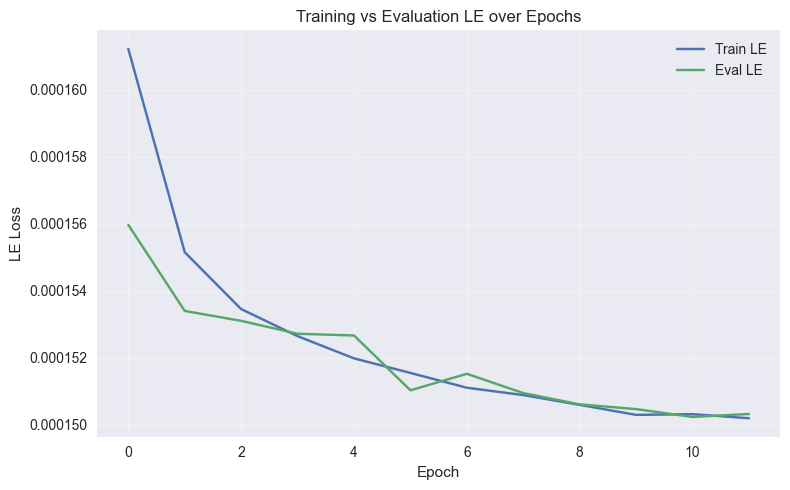

Final Train LE: 0.0001501907
Final Eval  LE: 0.0001503183


In [8]:
# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label=f'Train {loss_label}')
plt.plot(eval_losses, label=f'Eval {loss_label}')
plt.xlabel('Epoch')
plt.ylabel(f'{loss_label} Loss')
plt.title(f'Training vs Evaluation {loss_label} over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f'Final Train {loss_label}: {train_losses[-1]:.10f}')
print(f'Final Eval  {loss_label}: {eval_losses[-1]:.10f}')


Eval prediction summary:
  n=1,000,000 mean=0.174912 std=0.090417
  min=0.001789 p01=0.055202 p05=0.064283 p50=0.172356 p95=0.308787 p99=0.458247 max=0.631299
  label base_rate=0.166470 | logloss=0.420744 | brier=0.129864 | acc@0.5=0.833991
  Top 8 conditions by count:
       count  pred_mean  label_mean
cond                               
0     936024   0.173712    0.164497
1      44414   0.237208    0.236997
2      17189   0.094744    0.102391
3       2373   0.062907    0.088917


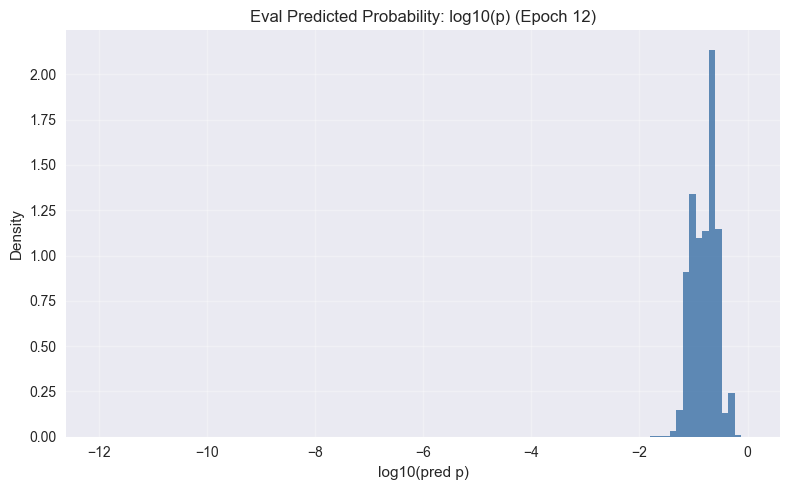

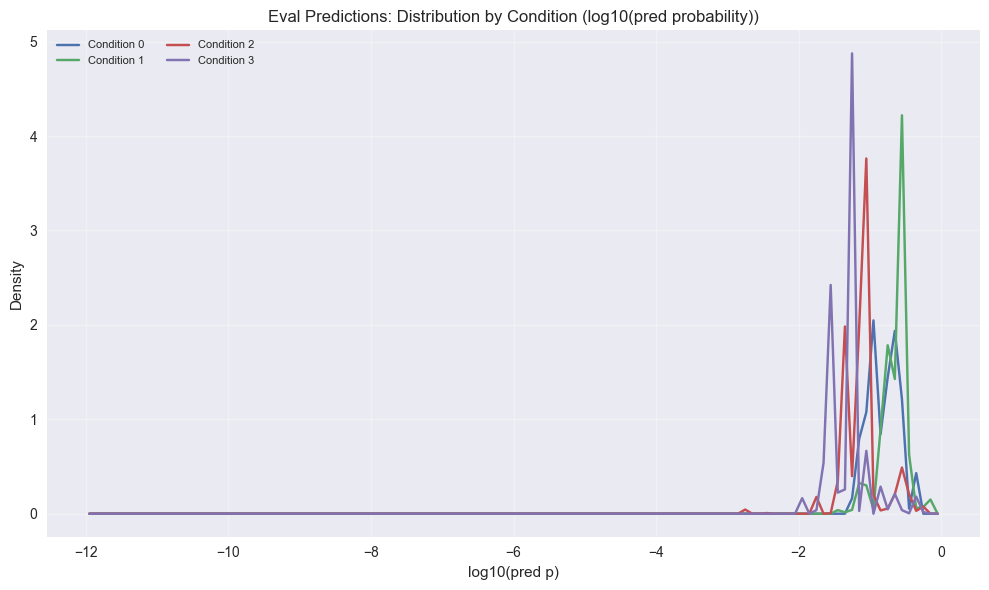

Final Evaluation LE: 0.0001503183
Final Evaluation BCE: 0.4207439922
Test prediction summary:
  n=4,577,464 mean=0.174890 std=0.088214
  min=0.004594 p01=0.058276 p05=0.066486 p50=0.180054 p95=0.332343 p99=0.458594 max=0.631771
  Top 8 conditions by count:
        count  pred_mean
cond                    
0     4342779   0.174762
1      167425   0.200628
2       57877   0.121723
3        9383   0.102458


In [9]:
# Final evaluation and plots analogous to input
def _print_pred_summary(
    name: str,
    preds: np.ndarray,
    labels: Optional[np.ndarray] = None,
    conds: Optional[np.ndarray] = None,
    top_k: int = 8,
) -> None:
    p = np.asarray(preds, dtype=np.float64).reshape(-1)
    q = np.quantile(p, [0.0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0])
    print(f"{name} prediction summary:")
    print(f"  n={p.size:,} mean={p.mean():.6f} std={p.std():.6f}")
    print(f"  min={q[0]:.6f} p01={q[1]:.6f} p05={q[2]:.6f} p50={q[3]:.6f} p95={q[4]:.6f} p99={q[5]:.6f} max={q[6]:.6f}")
    if labels is not None:
        y = np.asarray(labels, dtype=np.float64).reshape(-1)
        p_clip = np.clip(p, 1e-12, 1 - 1e-12)
        logloss = -np.mean(y * np.log(p_clip) + (1.0 - y) * np.log(1.0 - p_clip))
        brier = np.mean((p - y) ** 2)
        acc = np.mean((p >= 0.5) == (y >= 0.5))
        base_rate = float(np.mean(y))
        print(f"  label base_rate={base_rate:.6f} | logloss={logloss:.6f} | brier={brier:.6f} | acc@0.5={acc:.6f}")
    if conds is not None:
        df = pd.DataFrame({'cond': np.asarray(conds).reshape(-1), 'pred': p})
        if labels is not None:
            df['label'] = np.asarray(labels).reshape(-1)
            group = df.groupby('cond').agg(
                count=('pred', 'size'),
                pred_mean=('pred', 'mean'),
                label_mean=('label', 'mean'),
            )
        else:
            group = df.groupby('cond').agg(
                count=('pred', 'size'),
                pred_mean=('pred', 'mean'),
            )
        top = group.sort_values('count', ascending=False).head(top_k)
        print(f"  Top {top_k} conditions by count:")
        print(top.to_string(float_format=lambda x: f"{x:.6f}"))

# Evaluate on validation set
eval_loss, eval_preds = evaluate(
    model,
    eval_loader,
    device,
    loss_mode=LOSS_MODE,
    non_blocking=NON_BLOCKING,
)
eval_probs = np.clip(eval_preds, 1e-12, 1 - 1e-12)
_print_pred_summary('Eval', eval_preds, labels=y_ev, conds=cond_ev)

plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=epochs)

# Distribution plots for evaluation predictions vs conditions
_density_lines(
    values=eval_preds,
    groups=cond_ev,
    num_conditions=num_conditions,
    bins=120,
    transform='log10',
    value_range=(-12, 0),
    title='Eval Predictions: Distribution by Condition (log10(pred probability))',
    x_label='log10(pred p)'
)

print(f'Final Evaluation {loss_label}: {eval_loss:.10f}')
if EVAL_COMPARE_LOSSES:
    for mode in EVAL_COMPARE_LOSSES:
        if mode == LOSS_MODE:
            continue
        other_label = 'LE' if mode == 'localized_entropy' else 'BCE'
        other_loss, _ = evaluate(
            model,
            eval_loader,
            device,
            loss_mode=mode,
            non_blocking=NON_BLOCKING,
        )
        print(f'Final Evaluation {other_label}: {other_loss:.10f}')

# Test set prediction summary (no labels)
if test_loader is not None:
    test_preds = predict_probs(
        model,
        test_loader,
        device,
        non_blocking=NON_BLOCKING,
    )
    _print_pred_summary('Test', test_preds, labels=None, conds=cond_te)


/Users/spatiejunas/Developer/GitHub/LocalizedEntropy/.venv/lib/python3.14/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


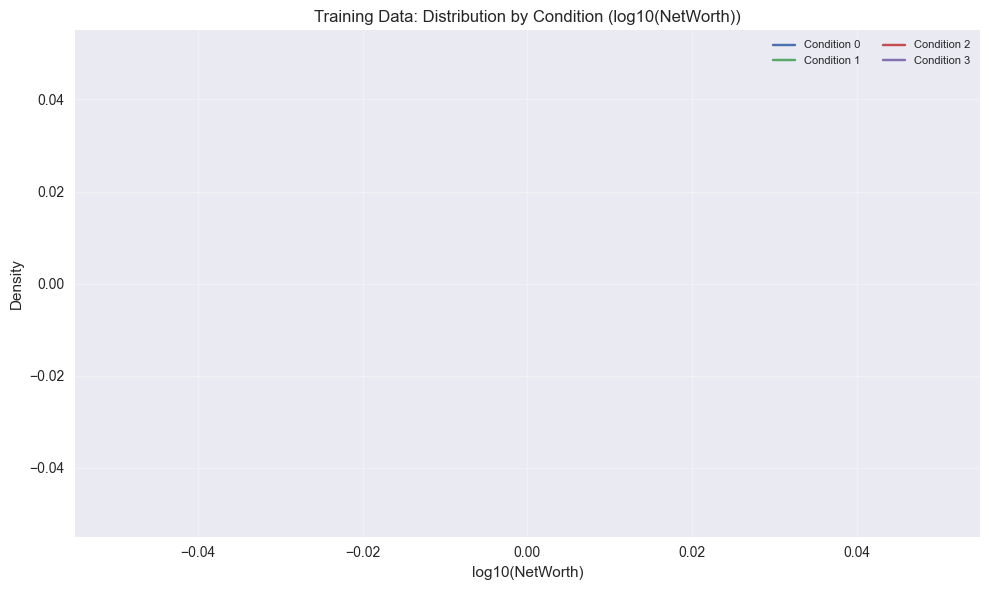

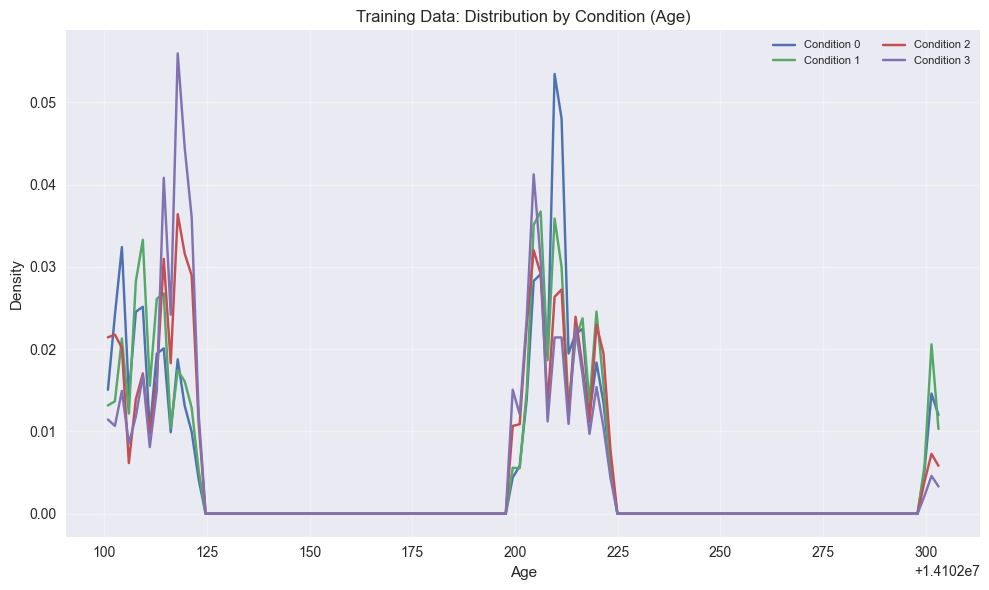

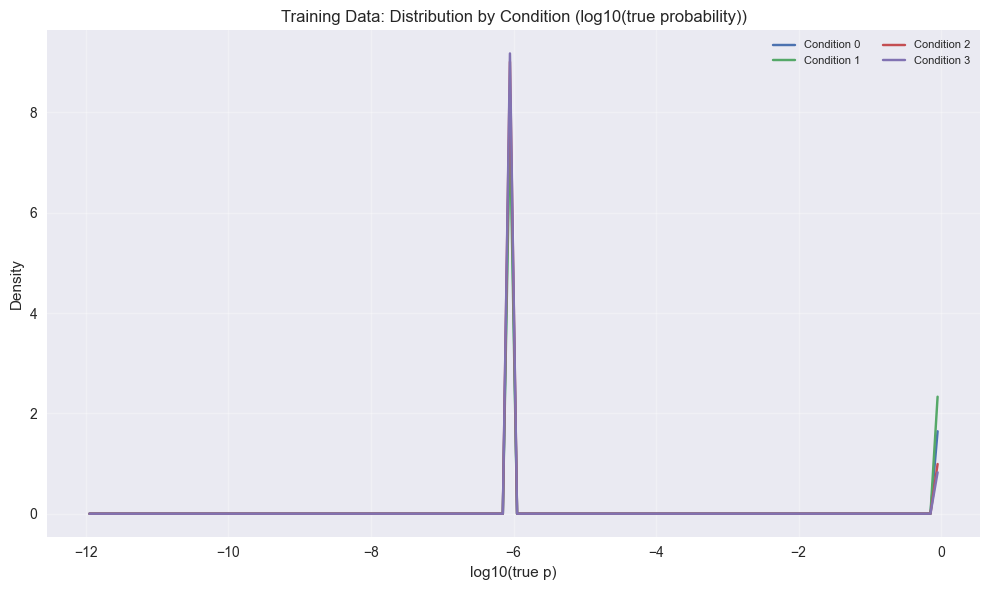

In [10]:
# Optional: render training data distributions after training
if PLOT_DATA_AFTER_TRAINING:
    plot_training_distributions(nw_tr, age_tr, p_tr, cond_tr, num_conditions)
else:
    print('Post-training training data plots are disabled. Set PLOT_DATA_AFTER_TRAINING=True to enable.')


In [11]:
# LE per-condition stats + plotting
import math
import numpy as np
import matplotlib.pyplot as plt

# Collect LE stats per condition
def collect_le_stats_per_condition(logits: torch.Tensor,
                                   targets: torch.Tensor,
                                   conditions: torch.Tensor,
                                   eps: float = 1e-12):
    """Compute LE numerator/denominator terms per condition using logits.
    Returns a dict: cond_id -> metrics.
    """
    z = logits.view(-1)
    y = targets.view(-1).to(z.dtype)
    c = conditions.view(-1).to(torch.long)

    # Stable BCE-with-logits per-sample
    bce_per = torch.clamp_min(z, 0) - z * y + torch.log1p(torch.exp(-torch.abs(z)))

    stats = {}
    for cid in torch.unique(c):
        mask = (c == cid)
        n = int(mask.sum().item())
        if n == 0:
            continue
        yj = y[mask]
        num = float(bce_per[mask].sum().item())
        ones = float(yj.sum().item())
        zeros = float(n) - ones
        pj = ones / max(1.0, float(n))
        pj = max(eps, min(1.0 - eps, pj))
        den = ones * (-math.log(pj)) + zeros * (-math.log1p(-pj))
        ratio = num / (den if den > eps else eps)
        stats[int(cid.item())] = {
            'Numerator': num,
            'Denominator': den,
            'Average prediction for denominator': pj,
            'Number of samples with label 1': int(round(ones)),
            'Number of samples with label 0': int(round(zeros)),
            'Numerator/denominator': ratio,
        }
    return stats

# Plotting function for LE stats
def plot_le_stats_per_condition(stats: dict,
                                title: str = 'Localized Entropy terms per condition'):
    conds = sorted(stats.keys())
    nums = [stats[c]['Numerator'] for c in conds]
    dens = [stats[c]['Denominator'] for c in conds]
    ratios = [stats[c]['Numerator/denominator'] for c in conds]
    pj = [stats[c]['Average prediction for denominator'] for c in conds]
    n1 = [stats[c]['Number of samples with label 1'] for c in conds]
    n0 = [stats[c]['Number of samples with label 0'] for c in conds]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Ratio
    axs[0, 0].bar(conds, ratios, color='#4477aa')
    axs[0, 0].set_title('Numerator / Denominator')
    axs[0, 0].set_xlabel('Condition')
    axs[0, 0].set_ylabel('Ratio')
    axs[0, 0].grid(True, alpha=0.3)

    # Numerator vs Denominator
    x = np.arange(len(conds))
    width = 0.4
    axs[0, 1].bar(x - width/2, nums, width=width, label='Numerator', color='#66c2a5')
    axs[0, 1].bar(x + width/2, dens, width=width, label='Denominator', color='#fc8d62')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(conds)
    axs[0, 1].set_title('Numerator vs Denominator')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # Counts
    axs[1, 0].bar(conds, n0, label='Label 0 count', color='#999999')
    axs[1, 0].bar(conds, n1, bottom=n0, label='Label 1 count', color='#1b9e77')
    axs[1, 0].set_title('Label counts per condition')
    axs[1, 0].set_xlabel('Condition')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # Base rate pj
    axs[1, 1].bar(conds, pj, color='#8da0cb')
    axs[1, 1].set_title('Average prediction for denominator (p_j)')
    axs[1, 1].set_xlabel('Condition')
    axs[1, 1].set_ylabel('p_j')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].grid(True, alpha=0.3)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

cond	num	den	avg_p	#y=1	#y=0	ratio
0	391712	418451	0.164497	153973	782051	0.936099
1	23171.1	24320.8	0.236997	10526	33888	0.952727
2	5202.25	5677.62	0.102391	1760	15429	0.916274
3	658.693	711.959	0.088917	211	2162	0.925184


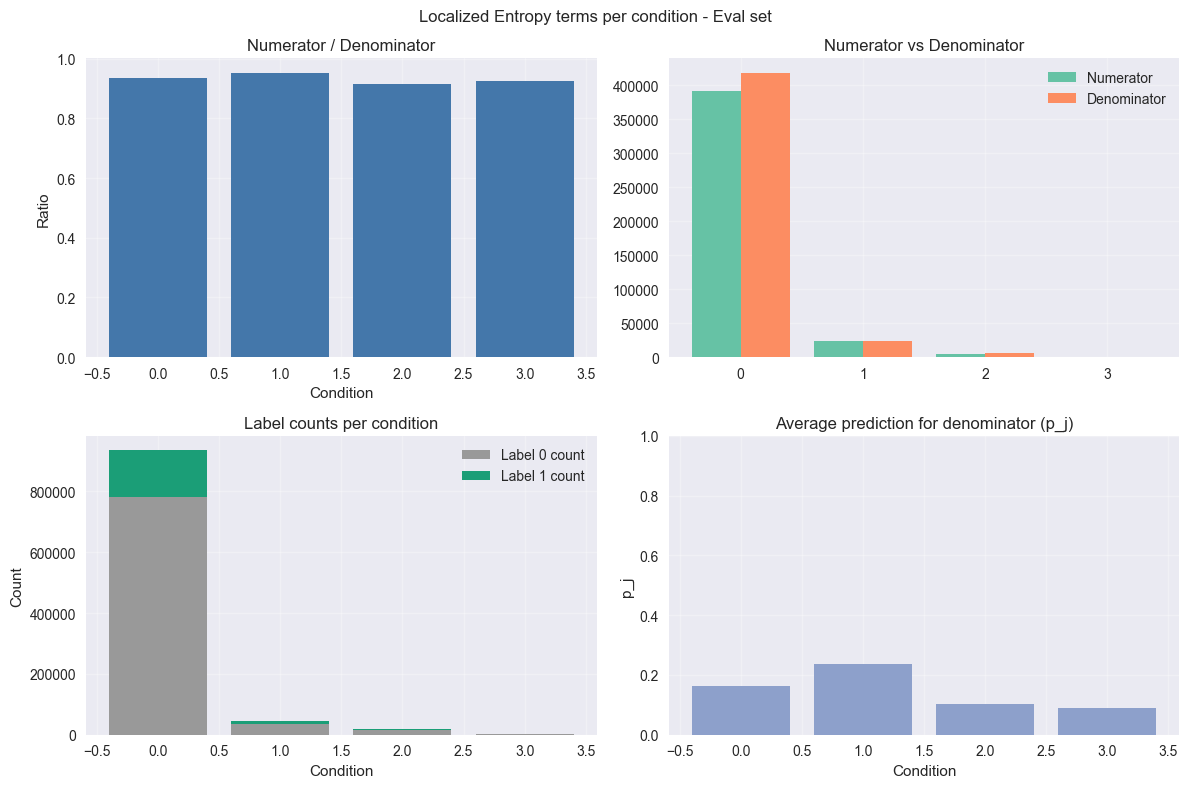

In [12]:

# Collect & plot LE stats per condition on eval set (using logits)
model.eval()
all_logits, all_targets, all_conditions = [], [], []
with torch.no_grad():
    for xb, cb, yb, nw in eval_loader:
        xb = xb.to(device, non_blocking=NON_BLOCKING)
        cb = cb.to(device, non_blocking=NON_BLOCKING)
        yb = yb.to(device, non_blocking=NON_BLOCKING)
        nw = nw.to(device, non_blocking=NON_BLOCKING)
        zb = model(xb, cb)
        all_logits.append(zb.detach().cpu())
        all_targets.append(yb.detach().cpu())
        all_conditions.append(cb.detach().cpu())
z_all = torch.cat(all_logits).view(-1)
y_all = torch.cat(all_targets).view(-1)
c_all = torch.cat(all_conditions).view(-1)

le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)

# Print table
print('cond	num	den	avg_p	#y=1	#y=0	ratio')
for cond in sorted(le_stats.keys()):
    s = le_stats[cond]
    print(f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	{s['Average prediction for denominator']:.6g}	{s['Number of samples with label 1']}	{s['Number of samples with label 0']}	{s['Numerator/denominator']:.6g}")

plot_le_stats_per_condition(le_stats, title='Localized Entropy terms per condition - Eval set')